# Hidden Markov Model

In [1]:
from tqdm import tqdm
from nltk import bigrams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
DATA_PATH = 'Brown_tagged_train.txt'

In [3]:
with open(DATA_PATH, 'r') as f:
    data = f.read().splitlines()
# data = map(lambda x: '<s>/<s> ' + x, data)
data = np.array(list(data))
unique_tags = ['ADP', 'DET', 'NOUN', 'VERB', 'ADJ', 'CONJ', 'PRT', '.', 'ADV', 'NUM', 'PRON', 'X']

In [4]:
def split_Xy(test_Xy):
    """
    test_Xy: List of list of tokens and tags
    Returns: List of tokens and list of tags
    """
    test_y = []
    test_X = []

    for sent in test_Xy:
        tagged_sent = sent.split(' ')
        sent_y = []
        sent_X = []

        for word in tagged_sent:
            if word == "":
                continue
            actual_word, tag = split_tag_word(word)
            sent_X.append(actual_word)
            sent_y.append(tag)
            
        test_y.append(sent_y)
        test_X.append(sent_X)

    return test_X, test_y

In [5]:
def split_tag_word(inp):
    """
    Returns word, tag for the given input
    """
    arr = inp.split('/')
    tag = arr[-1]
    del arr[-1]
    word = '/'.join(arr)
    return word, tag

In [6]:
def create_params(train_set):
    """
    Returns a dictionary of parameters
    tokens = Tokens present in the vocabulary
    tags = Tags present in the vocabulary
    token_tag = Count of each word/tag pair for emmission probability
    tag_pair = Count of each tag pair for transition probability
    vocabulary = Vocabulary of the training set
    Create params for HMM
    """
    tagged_sentences = []
    for sent in train_set:
        tagged_sentences.append(sent.split(' '))

    # list of list of tokens in the training set. Each internal set denotes a sentence.
    tokens = []
    tag_freq = {}  # list of all tags
    token_tag = {}  # dictionary of token/tag
    tag_pair = {}  # dictionary of tag tag
    vocab = set()

    # Create vocab, tokens, tags, token_tag
    for sentence in tagged_sentences:
        sentence_tokens = []  # all tokens for a sentence
        for word in sentence:
            if word == "":
                continue
            token_tag[word] = token_tag.get(word, 0) + 1
            actual_word, tag = split_tag_word(word)
            tag_freq[tag] = tag_freq.get(tag, 0) + 1
            vocab.add(actual_word)
            sentence_tokens.append(actual_word)
        tokens.append(sentence_tokens)

    # Create tag_pair
    for sentence in tagged_sentences:
        tag_bigram = bigrams(sentence)
        for t in tag_bigram:
            if t[0] == '' or t[1] == '':
                continue
            tag_1 = split_tag_word(t[0])[1]
            tag_2 = split_tag_word(t[1])[1]
            key = tag_1 + ' ' + tag_2
            tag_pair[key] = tag_pair.get(key, 0) + 1

    print("Vocabulary Length: ", len(vocab))
    print("Number of Tags: ", len(tag_freq.keys()))
    print(tag_freq)
    print("Number of Token/Tag: ", len(token_tag.keys()))
    print("Number of Tag Tag: ", len(tag_pair.keys()))
    return {
        "vocab": vocab,
        "tokens": tokens,
        "tag_freq": tag_freq,
        "token_tag": token_tag,
        "tag_pair": tag_pair
    }

In [7]:
def viterbi(params, sentence):
    """
    Takes a test sentence and returns predictions
    """
    vocab = params['vocab']
    tag_freq = params['tag_freq']
    tags = list(tag_freq.keys())
    token_tag = params['token_tag']
    tag_pair = params['tag_pair']
    prev_tag = '.'
    chosen_tags = []

    for word in sentence:
        count_emiss = True

        if word == "" or word not in vocab:
            count_emiss = False
            # chosen_tags.append('.')
            # In case of OOV words, choose the tag with the highest probability, Basically only the transition probability
            # print("Invalid token found: ", word)
            # continue
        probs = []

        for tag in tags:
            # Transmission probability
            p_trans = tag_pair.get(prev_tag + ' ' + tag,
                                   0) / tag_freq.get(prev_tag, -1)
            if count_emiss:
                # Emmission probability (only counted if the word is not OOV)
                p_emiss = token_tag.get(
                    word + "/" + tag, 0) / tag_freq.get(tag, -1)
                probs.append(p_trans * p_emiss)
            else:
                probs.append(p_trans)

        chosen_tag = tags[np.argmax(probs)]
        prev_tag = chosen_tag
        chosen_tags.append(chosen_tag)

    return chosen_tags

In [8]:
def HMM(train, test, create_params, viterbi):
    """
    Takes trainset and test sentences and returns predictions
    """
    params = create_params(train)

    preds = []
    for i in tqdm(range(len(test))):
        sentence = test[i]
        predicted_tags = viterbi(params, sentence)
        preds.append(predicted_tags)

    tag_freq = params['tag_freq']
    tags = list(tag_freq.keys())

    return tags, preds

In [9]:
def evaluate_HMM(tags, preds, test_y, to_print=True):
    """
    tags: List of tags
    preds: List of list of predicted tags
    test_y: List of list of actual tags
    """
    # for i in range(len(test_y)):
    #     for j in range(len(test_y[i])):

    flat_tags = [item for elem in test_y for item in elem]
    flat_preds = [item for elem in preds for item in elem]

    accuracy = accuracy_score(flat_tags, flat_preds)
    precision = precision_score(flat_tags, flat_preds, average='weighted')
    recall = recall_score(flat_tags, flat_preds, average='weighted')
    f1_score = (2 * precision * recall) / (precision + recall)

    tagwise_precision = precision_score(
        flat_tags, flat_preds, labels=tags, pos_label=None, average=None)
    tagwise_recall = recall_score(
        flat_tags, flat_preds, labels=tags, pos_label=None, average=None)
    tagwise_f1 = (2 * tagwise_precision * tagwise_recall) / \
        (tagwise_precision + tagwise_recall)

    cm = confusion_matrix(flat_tags, flat_preds)

    # cm = np.zeros((len(tags), len(tags)))

    # for sent_y, sent_pred in zip(test_y, preds):
    #     for tag, pred in zip(sent_y, sent_pred):
    #         cm[tags.index(tag)][tags.index(pred)] += 1

    if to_print:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score", f1_score)
        print("Tagwise Precision: ", tagwise_precision)
        print("Tagwise Recall: ", tagwise_recall)
        print("Tagwise F1 score: ", tagwise_f1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
        disp.plot()
        plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1-score": f1_score,
        "cm": cm,
        "tagwise_precision": tagwise_precision,
        "tagwise_recall": tagwise_recall,
        "tagwise_f1": tagwise_f1
    }


In [10]:
def KFoldHMM(data, create_params, viterbi):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    unique_tags = []
    metrics = []
    for train_index, test_index in kf.split(data):
        train_set, test_Xy = data[train_index], data[test_index]
        test_X, test_y = split_Xy(test_Xy)
        tags, preds = HMM(train_set, test_X, create_params, viterbi)
        unique_tags = tags
        metrics.append(evaluate_HMM(tags, preds, test_y, to_print=False))

    print("Average metrics: ")
    precision, recall, f1, accuracy = 0, 0, 0, 0
    tagwise_precision, tagwise_recall, tagwise_f1 = np.zeros(
        len(unique_tags)), np.zeros(len(unique_tags)), np.zeros(len(unique_tags))

    cm = np.zeros((len(unique_tags), len(unique_tags)))

    for metric_dict in metrics:
        accuracy += metric_dict['accuracy']
        precision += metric_dict["precision"]
        recall += metric_dict["recall"]
        f1 += metric_dict["f1-score"]
        tagwise_precision += metric_dict["tagwise_precision"]
        tagwise_recall += metric_dict["tagwise_recall"]
        tagwise_f1 += metric_dict["tagwise_f1"]
        cm += metric_dict["cm"]

    accuracy /= len(metrics)
    precision /= len(metrics)
    recall /= len(metrics)
    f1 /= len(metrics)
    tagwise_precision /= len(metrics)
    tagwise_recall /= len(metrics)
    tagwise_f1 /= len(metrics)
    cm /= len(metrics)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=unique_tags)
    disp.plot()
    fig = disp.figure_
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.show()
    return {
        "accuracy": accuracy, 
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1,
        "tagwise_precision" : tagwise_precision,
        "tagwise_recall" : tagwise_recall,
        "tagwise_f1" : tagwise_f1,
        "cm" : cm
    }
    # print("Precision: ", precision)
    # print("Recall: ", recall)
    # print("F1 score: ", f1)
    # # create df of tagwise metrics
    # tagwise_metrics = pd.DataFrame(
    #     {
    #         "tag": unique_tags,
    #         "precision": tagwise_precision,
    #         "recall": tagwise_recall,
    #         "f1-score": tagwise_f1
    #     }
    # )
    # print(tagwise_metrics)
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix=cm, display_labels=unique_tags)
    # disp.plot()
    # fig = disp.figure_
    # fig.set_figwidth(12)
    # fig.set_figheight(12)
    # plt.show()


Vocabulary Length:  27813
Number of Tags:  12
{'ADP': 43660, 'DET': 42087, 'NOUN': 80317, 'VERB': 59540, 'ADJ': 24131, 'CONJ': 11867, 'PRT': 10219, '.': 47569, 'ADV': 18429, 'NUM': 4360, 'PRON': 18010, 'X': 398}
Number of Token/Tag:  29593
Number of Tag Tag:  140


100%|██████████| 9164/9164 [00:12<00:00, 719.30it/s]


Vocabulary Length:  27702
Number of Tags:  12
{'VERB': 60045, 'ADJ': 24352, 'NOUN': 80458, 'DET': 42158, 'ADP': 43855, '.': 47682, 'CONJ': 11875, 'ADV': 18457, 'PRON': 18081, 'PRT': 10510, 'NUM': 4454, 'X': 398}
Number of Token/Tag:  29491
Number of Tag Tag:  141


100%|██████████| 9164/9164 [00:04<00:00, 1969.10it/s]


Vocabulary Length:  27748
Number of Tags:  12
{'ADP': 44207, 'DET': 42083, 'NOUN': 80765, 'VERB': 59947, 'ADJ': 24449, 'CONJ': 11816, 'PRT': 10515, '.': 47859, 'ADV': 18480, 'NUM': 4514, 'PRON': 18367, 'X': 384}
Number of Token/Tag:  29544
Number of Tag Tag:  141


100%|██████████| 9163/9163 [00:04<00:00, 2073.59it/s]


Average metrics: 


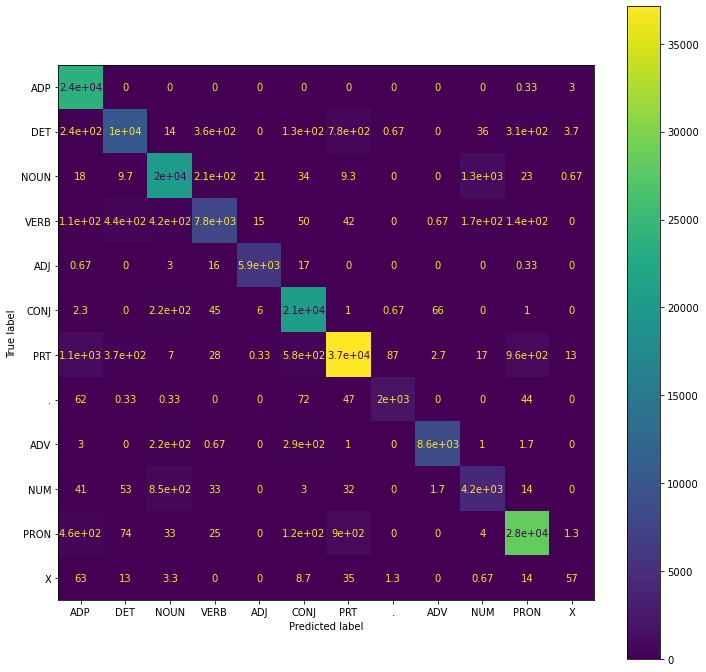

In [11]:
q1a_metrics = KFoldHMM(data, create_params, viterbi)    

## Emission Probabilities

P(word | state) = count(word, state) / count(state)

## Transition Probabilities

P(state | state-1) = count(state, state-1) / count(state-1)

# Optional Length 2 Markov Model

In [12]:
from nltk import trigrams

In [13]:
def create_params(train_set):
    """
    Returns a dictionary of parameters
    tokens = Tokens present in the vocabulary
    tags = Tags present in the vocabulary
    token_tag = Count of each word/tag pair for emmission probability
    tag_pair = Count of each tag pair for transition probability
    vocabulary = Vocabulary of the training set
    Create params for HMM
    """
    tagged_sentences = []
    for sent in train_set:
        tagged_sentences.append(sent.split(' '))

    # list of list of tokens in the training set. Each internal set denotes a sentence.
    tokens = []
    tag_freq = {}  # list of all tags
    token_tag = {}  # dictionary of token/tag
    tag_pair = {}  # dictionary of tag tag
    tag_triplet = {}  # dictionary of tag tag
    vocab = set()

    # Create vocab, tokens, tags, token_tag
    for sentence in tagged_sentences:
        sentence_tokens = []  # all tokens for a sentence
        for word in sentence:
            if word == "":
                continue
            token_tag[word] = token_tag.get(word, 0) + 1
            actual_word, tag = split_tag_word(word)
            tag_freq[tag] = tag_freq.get(tag, 0) + 1
            vocab.add(actual_word)
            sentence_tokens.append(actual_word)
        tokens.append(sentence_tokens)

    # Create tag_pair
    for sentence in tagged_sentences:
        tag_bigram = bigrams(sentence)
        for t in tag_bigram:
            if t[0] == '' or t[1] == '':
                continue
            tag_1 = split_tag_word(t[0])[1]
            tag_2 = split_tag_word(t[1])[1]
            key = tag_1 + ' ' + tag_2
            tag_pair[key] = tag_pair.get(key, 0) + 1
        tag_trigram = trigrams(sentence)
        for t in tag_trigram:
            if t[0] == '' or t[1] == '' or t[2] == '':
                continue
            tag_1 = split_tag_word(t[0])[1]
            tag_2 = split_tag_word(t[1])[1]
            tag_3 = split_tag_word(t[2])[1]
            key = tag_1 + ' ' + tag_2 + ' ' + tag_3
            tag_triplet[key] = tag_triplet.get(key, 0) + 1

    print("Vocabulary Length: ", len(vocab))
    print("Number of Tags: ", len(tag_freq.keys()))
    print(tag_freq)
    print("Number of Token/Tag: ", len(token_tag.keys()))
    print("Number of Tag Tag: ", len(tag_pair.keys()))
    print("Number of Tag Tag Tag: ", len(tag_triplet.keys()))
    return {
        "vocab": vocab,
        "tokens": tokens,
        "tag_freq": tag_freq,
        "token_tag": token_tag,
        "tag_pair": tag_pair,
        "tag_triplet": tag_triplet
    }

In [14]:
def viterbi(params, sentence):
    """
    Takes a test sentence and returns predictions
    """
    vocab = params['vocab']
    tag_freq = params['tag_freq']
    tags = list(tag_freq.keys())
    token_tag = params['token_tag']
    tag_pair = params['tag_pair']
    tag_triplet = params['tag_triplet']
    prev_tag = '.'
    prev2_tag = '.'
    chosen_tags = []

    for word in sentence:
        count_emiss = True

        if word == "" or word not in vocab:
            count_emiss = False
            # chosen_tags.append('.')
            # In case of OOV words, choose the tag with the highest probability, Basically only the transition probability
            # print("Invalid token found: ", word)
            # continue
        probs = []

        for tag in tags:
            # Transmission probability
            p_trans = tag_triplet.get(prev2_tag + ' ' + prev_tag + ' ' + tag, 0)/ tag_pair.get(prev2_tag + ' ' + prev_tag, -1)
            p_trans *= tag_pair.get(prev_tag + ' ' + tag, 0) / tag_freq.get(prev_tag, -1)
            
            if count_emiss:
                # Emmission probability (only counted if the word is not OOV)
                p_emiss = token_tag.get(
                    word + "/" + tag, 0) / tag_freq.get(tag, -1)
                probs.append(p_trans * p_emiss)
            else:
                probs.append(p_trans)

        chosen_tag = tags[np.argmax(probs)]
        prev2_tag = prev_tag
        prev_tag = chosen_tag

        chosen_tags.append(chosen_tag)

    return chosen_tags

Vocabulary Length:  27813
Number of Tags:  12
{'ADP': 43660, 'DET': 42087, 'NOUN': 80317, 'VERB': 59540, 'ADJ': 24131, 'CONJ': 11867, 'PRT': 10219, '.': 47569, 'ADV': 18429, 'NUM': 4360, 'PRON': 18010, 'X': 398}
Number of Token/Tag:  29593
Number of Tag Tag:  140
Number of Tag Tag Tag:  1350


100%|██████████| 9164/9164 [00:05<00:00, 1535.81it/s]


Vocabulary Length:  27702
Number of Tags:  12
{'VERB': 60045, 'ADJ': 24352, 'NOUN': 80458, 'DET': 42158, 'ADP': 43855, '.': 47682, 'CONJ': 11875, 'ADV': 18457, 'PRON': 18081, 'PRT': 10510, 'NUM': 4454, 'X': 398}
Number of Token/Tag:  29491
Number of Tag Tag:  141
Number of Tag Tag Tag:  1355


100%|██████████| 9164/9164 [00:06<00:00, 1445.18it/s]


Vocabulary Length:  27748
Number of Tags:  12
{'ADP': 44207, 'DET': 42083, 'NOUN': 80765, 'VERB': 59947, 'ADJ': 24449, 'CONJ': 11816, 'PRT': 10515, '.': 47859, 'ADV': 18480, 'NUM': 4514, 'PRON': 18367, 'X': 384}
Number of Token/Tag:  29544
Number of Tag Tag:  141
Number of Tag Tag Tag:  1363


100%|██████████| 9163/9163 [00:15<00:00, 584.36it/s]


Average metrics: 


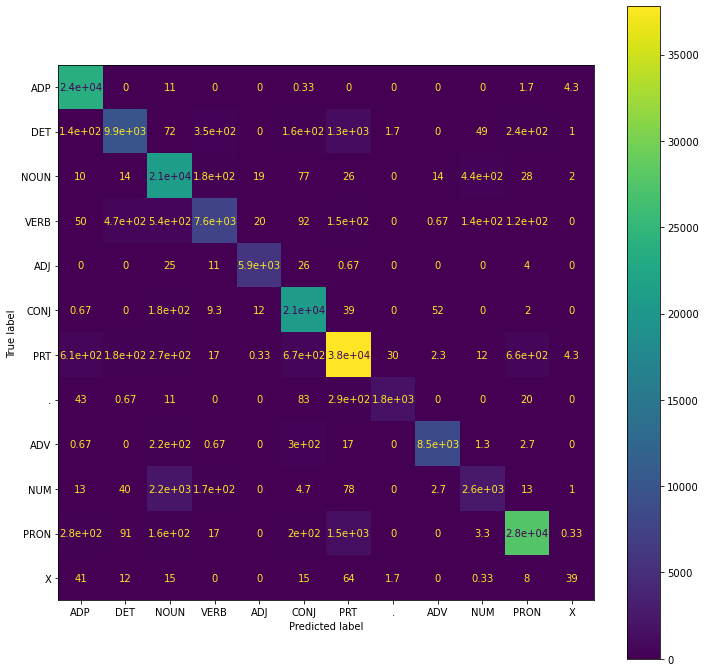

In [15]:
q1b_metrics = KFoldHMM(data, create_params, viterbi)
# kf = KFold(n_splits=3, shuffle=True, random_state=42)

# unique_tags = []
# metrics = []
# for train_index, test_index in kf.split(data):
#     train_set, test_Xy = data[train_index], data[test_index]
#     test_X, test_y = split_Xy(test_Xy)
#     tags, preds = HMM(train_set, test_X)
#     unique_tags = tags
#     metrics.append(evaluate_HMM(tags, preds, test_y, to_print=False))

In [16]:
def compare_metrics(metrics):
    """
    Metrics is an array of dictionaries with the following values:
        "accuracy": Accuracy for all tags,
        "precision": Precision for all tags
        "recall": Recall for all tags
        "f1-score": F1 score for all tags
        "cm": Confusion Matrix
        "tagwise_precision" : array of precision based on tag
        "tagwise_recall": array of recall based on tag
        "tagwise_f1": array of f1 scores based on tag,
        "model_name": Display Name of the model,
        "model_df_name": Name of the model to be stored in df columns 
    """
    num_models = len(metrics)
    metric_df = pd.DataFrame(
        {
            "model_name": [metrics[i]["model_name"] for i in range(num_models)],
            "accuracy": [metrics[i]["accuracy"] for i in range(num_models)],
            "precision": [metrics[i]["precision"] for i in range(num_models)],
            "recall": [metrics[i]["recall"] for i in range(num_models)],
            "f1-score": [metrics[i]["f1-score"] for i in range(num_models)]
        }
    )
    tagwise_metric_df = pd.DataFrame(
        {
            "tag": unique_tags
        }
    )
    for i in range(len(metrics)):
        tagwise_metric_df["precision_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_precision"]
    for i in range(len(metrics)):
        tagwise_metric_df["recall_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_recall"]
    for i in range(len(metrics)):
        tagwise_metric_df["f1_" + metrics[i]["model_df_name"]] = metrics[i]["tagwise_f1"]
    return metric_df, tagwise_metric_df


In [17]:
q1a_metrics['model_name'] = "HMM"
q1a_metrics['model_df_name'] = "HMM"
q1b_metrics['model_name'] = "HMM Optional"
q1b_metrics['model_df_name'] = "HMMb"

In [18]:
metric_df, tagwise_metric_df = compare_metrics([q1a_metrics, q1b_metrics])

In [19]:
metric_df

,model_name,accuracy,precision,recall,f1-score
0,HMM,0.934288,0.934971,0.934288,0.934629
1,HMM Optional,0.925617,0.925731,0.925617,0.925674


In [20]:
tagwise_metric_df

,tag,precision_HMM,precision_HMMb,recall_HMM,recall_HMMb,f1_HMM,f1_HMMb
0,ADP,0.927881,0.885120,0.934325,0.950680,0.931088,0.915364
1,DET,0.932602,0.926729,0.936486,0.926712,0.933730,0.924853
2,NOUN,0.952553,0.916841,0.922200,0.938739,0.937121,0.927659
3,VERB,0.948148,0.950318,0.957994,0.945191,0.952887,0.947181
4,ADJ,0.916944,0.900266,0.874352,0.862799,0.894771,0.878019
5,CONJ,0.968926,0.977792,0.996005,0.992252,0.981933,0.984830
6,PRT,0.825178,0.870711,0.866165,0.667837,0.844828,0.746073
7,.,0.918396,0.940170,0.948445,0.940852,0.931809,0.939346
8,ADV,0.941688,0.935577,0.880705,0.866358,0.910157,0.899586
9,NUM,0.875749,0.917480,0.871675,0.708741,0.872721,0.797294


In [21]:
with open('HMM_metrics.pkl', 'wb') as f:
    import pickle
    HMM_metrics = [q1a_metrics, q1b_metrics]
    pickle.dump(HMM_metrics, f)

In [22]:
with open('unique_tags.pkl', "wb") as f:
    import pickle
    pickle.dump(unique_tags, f)